<center><h1>Предобработка текста и определение языка</h1></center>


### Вариант А

Написать классификатор для автоматического определения языка текста.
Данные:
Выбрать 4 языка с похожими алфавитами.
Набрать обуч. выборку — (хотя бы) по 100 статей из википедии на каждый язык. Бонус: скачать дампы википедии для выбранных языков, почистить и использовать в качестве обучающей выборки их.
Проверочная выборка: скачать (хотя бы) по 30 статей из википедии на каждый язык.

Признаки для обучения (векторизация документов): символьные триграммы.

Предобработка:
Удалить из всех текстов символы/токены/части документов, которые добавят шума на этапе векторизации или затруднят классификацию.
Выбрать по 3 статьи для каждого языка и подробно описать свои решения по препроцессингу.

Векторизовав тексты, построить матрицу схожести текстов, визуализировать её.

Какие языки оказались очень похожи друг на друга, а какие нет? Иными словами, какие языки проще различить по нграммам, а какие труднее? Выбрать один язык. С какими языками его легко спутать (по вашей векторизации)?

Обучить классификатор (например, NaiveBayes или SVM).
Оценить качество работы системы: посчитать точность, полноту, f-меру.

Сколько обучающих данных достаточно для получения хороших результатов? Бонус: график зависимости accuracy от объёма обучающей выборки.
Сравните качество класификации на униграммах, биграммах, 3-граммах, 4-граммах, 5-граммах. Бонус: постройте такой график. 
Какие именно нграммы оказались наиболее полезными признаками? (например, содержащие символы, которые используются лишь в одно алфавите?)
Интерпретировать результаты.

Оформление: в свой репозиторий загрузить папку langdetect_a_hw, в которой должны быть:
lang_detect_results.txt (или .md или .pdf) с описанием всех ваших шагов (сколько каких текстов взяли, какие методы использовали, какие результаты получились). Описание шага предобработки — обязательно;
проверочная выборка, на которой вы тестировали классификатор (или, что предпочтительнее, файл с ссылками на статьи википедии, которые вы использовали);
код в .ipynb либо .py;


In [3]:
import wikipedia
from collections import defaultdict
from time import sleep
from pickle import dump, load
from itertools import chain
from pandas import DataFrame
import re

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [5]:
languages = ['en', 'fr', 'cz', 'es']
pages, labels = defaultdict(lambda: []), defaultdict(lambda: [])

In [6]:
import warnings
warnings.filterwarnings('ignore')


Для препроцессинга были выбраны регулярные выражения, ощичающие текст до формата: "слова без чисел, знаков препинания, знаков табуляции, разделенные пробелами"

In [7]:
def normalize(text):
    reg_exps = (re.compile('[^\w ]+'), re.compile('[\d]+'), re.compile('[ ]+'))
    for reg in reg_exps:
        text = reg.sub(' ', text)
    return text.strip()

Сравните:

In [12]:
wikipedia.set_lang(languages[0])
for page_title in wikipedia.random(1):
    title = page_title
    article = wikipedia.page(str(wikipedia.search(title)[0])).content
print(article)

The grapheme Ć (minuscule: ć), formed from C with the addition of an acute accent, is used in various languages. It usually denotes [t͡ɕ], the voiceless alveolo-palatal affricate, including in phonetic transcription. Its Unicode codepoints are U+0106 for Ć and U+0107 for ć.
The symbol originated in the Polish alphabet (where, in its modern usage, it appears most often at the ends of words) and was adopted by Croatian linguist Ljudevit Gaj into Serbo-Croatian in the 19th century. It is the fifth letter of the Polish, Sorbian, and Gaj's Latin alphabet of Serbo-Croatian language. It is fourth in the Belarusian Łacinka alphabet.
It is also adopted by Wymysorys a West-Germanic language spoken in Poland. It is also the fifth letter of the Wymysorys alphabet.
In Slovenian, it occurs only in loanwords, mainly from Serbo-Croatian (such as the surname Handanović), and denotes the same sound as Č, i.e. the voiceless palato-alveolar affricate.
The Serbian Cyrillic alphabet equivalent is ⟨Ћ⟩. Maced

In [13]:
normalize(article)

'The grapheme Ć minuscule ć formed from C with the addition of an acute accent is used in various languages It usually denotes t ɕ the voiceless alveolo palatal affricate including in phonetic transcription Its Unicode codepoints are U for Ć and U for ć The symbol originated in the Polish alphabet where in its modern usage it appears most often at the ends of words and was adopted by Croatian linguist Ljudevit Gaj into Serbo Croatian in the th century It is the fifth letter of the Polish Sorbian and Gaj s Latin alphabet of Serbo Croatian language It is fourth in the Belarusian Łacinka alphabet It is also adopted by Wymysorys a West Germanic language spoken in Poland It is also the fifth letter of the Wymysorys alphabet In Slovenian it occurs only in loanwords mainly from Serbo Croatian such as the surname Handanović and denotes the same sound as Č i e the voiceless palato alveolar affricate The Serbian Cyrillic alphabet equivalent is Ћ Macedonian uses Ќ as a partial equivalent Other la

Тоже самое происходит и с другими языками: например, с испанским:

In [26]:
wikipedia.set_lang(languages[3])
for page_title in wikipedia.random(1):
    title = page_title
    if 'disambig' in page_title: 
            title = page_title.split(' ')[0] 
    article = wikipedia.page(str(wikipedia.search(title)[0])).content
print(article)

La n (en mayúscula N, nombre ene, plural enes) es la decimocuarta letra y la undécima consonante del alfabeto español y del alfabeto latino básico.
En español representa un fonema sonante, nasal y alveolar.[1]​


== Historia ==
Se corresponde con la letra N del alfabeto latino o romano. La letra semítica Nûn era probablemente la imagen de una serpiente. La n es el origen de la virgulilla (~).


== Uso fonético ==
En la norma culta del español en España y América, la grafía N tiene una articulación alveolar nasal, /n/, con la punta de la lengua apoyada en la montaña alveolar, justo encima de los incisivos superiores. Esta /n/ suele asimilarse al punto de articulación de la consonante que le sigue; así la /n/ es dental delante de /t/ (antes), velar [ŋ] delante de /x/, /k/ y /g/ (baŋco, coŋ gente), bilabial [m] delante de /m/ (inmóvil, con matices) o /b/ (han bombardeado).
A pesar de lo dicho anteriormente, en extensas áreas de América y España la -n final e implosiva, no se articula alve

In [27]:
normalize(article)

'La n en mayúscula N nombre ene plural enes es la decimocuarta letra y la undécima consonante del alfabeto español y del alfabeto latino básico En español representa un fonema sonante nasal y alveolar Historia Se corresponde con la letra N del alfabeto latino o romano La letra semítica Nûn era probablemente la imagen de una serpiente La n es el origen de la virgulilla Uso fonético En la norma culta del español en España y América la grafía N tiene una articulación alveolar nasal n con la punta de la lengua apoyada en la montaña alveolar justo encima de los incisivos superiores Esta n suele asimilarse al punto de articulación de la consonante que le sigue así la n es dental delante de t antes velar ŋ delante de x k y g baŋco coŋ gente bilabial m delante de m inmóvil con matices o b han bombardeado A pesar de lo dicho anteriormente en extensas áreas de América y España la n final e implosiva no se articula alveolar n sino velar ŋ Esta articulación es igual a la de la n seguida de consona

Таким образом, соберем 200 статей из Википедии (по 50 для каждого из 4 языков):

In [7]:
for language_id, language in enumerate(languages):
    wikipedia.set_lang(language)
    for page_title in wikipedia.random(50):
        title = page_title
        if 'disambig' in page_title: 
            title = page_title.split(' ')[0] 
        while(True):
            try:
                normalized_text = normalize(wikipedia.page(str(wikipedia.search(title)[0])).content)
                pages[language].append(normalized_text)
                labels[language].append(language_id)
                break
            except wikipedia.DisambiguationError:
                title = wikipedia.random(1)

In [8]:
data = DataFrame(list(zip(list(chain.from_iterable(pages[language] for language in languages)), 
                          list(chain.from_iterable(labels[language] for language in languages)))),
                          columns=['text', 'language'])

In [9]:
data.to_csv('wikipedia_languages.csv', encoding='utf-8')

In [99]:
data = DataFrame.from_csv('wikipedia_languages.csv', encoding='utf-8')

In [100]:
train, test = train_test_split(data, test_size=0.2)

In [101]:
select = SelectPercentile(percentile=100)
clf = LogisticRegression(tol=1e-8, penalty='l2', C=1)
svm1 = svm.LinearSVC()
svm2 = svm.SVC()
countvect_char_wb =[CountVectorizer(ngram_range=(3, 3), analyzer='char_wb'), TfidfVectorizer(ngram_range=(1, 3), analyzer='char', binary=False)]

[2 3 0 1 1]


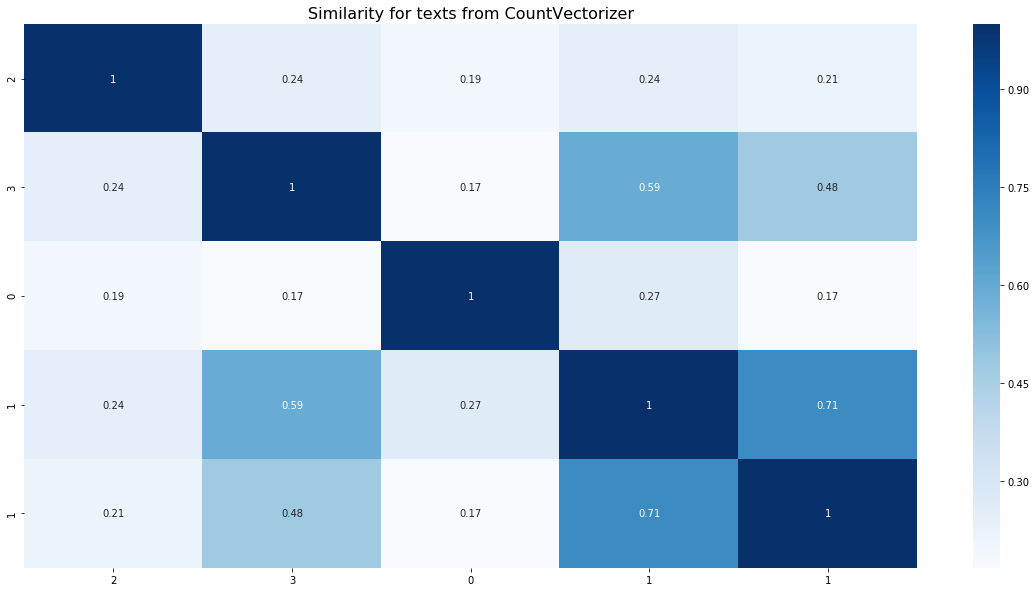

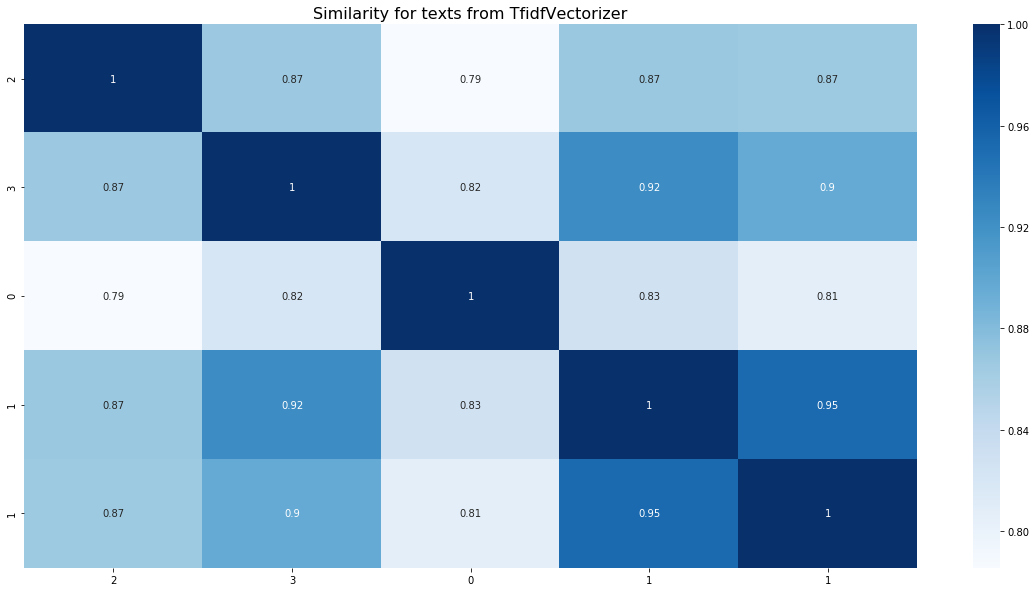

In [129]:
print(train.language.values[20:25])
for countvect in countvect_char_wb:
    sp_matrix = countvect.fit_transform(train.text.values[20:25], train.language.values[20:25])
    similarities = cosine_similarity(sp_matrix)
    df_cm = DataFrame(similarities, columns=train.language.values[20:25], index=train.language.values[20:25])
    plt.figure(figsize=(20,10))
    plt.title('Similarity for texts from '+re.findall(".+Vectorizer",str(repr(countvect)))[0], fontsize=16)
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.show()

In [103]:
for countvect in countvect_char_wb:
    char_model = Pipeline([('vect', countvect), ('select', select), ('logr', clf)])
    char_model.fit(train.text.values, train.language.values)
    print(f1_score(char_model.predict(test.text.values), test.language.values, average='micro'))

1.0
0.5
